In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#импортируем все необходимые для работы библиотеки

import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
from matplotlib import rcParams
from datetime import datetime, date, time
import numpy as np
import seaborn as sns
from scipy import stats as st
from plotly.subplots import make_subplots
import math
pd.set_option('display.max_columns', 100)

from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go
import plotly.express as px

import plotly.io as pio
pio.renderers.default = 'colab'

init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

## Изучение данных из файла

In [3]:
#прочитаем данные из файла

games = pd.read_csv('/content/drive/My Drive/Collab file/games.csv')

In [4]:
# функция для распаковки данных

def open_data(data):
  display(data.head())
  print('------------------------')
  print('Общая информация')
  data.info()
  print('------------------------')
  print('Описание данных')
  display(data.describe())
  print('------------------------')
  print('Количество дубликатов')
  print(data.duplicated().sum())
  print('------------------------')
  print('Количество пропусков')
  display(data.isna().sum())

### Знакомтсво с данными

In [5]:
open_data(games)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


------------------------
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
------------------------
Описание данных


,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


------------------------
Количество дубликатов
0
------------------------
Количество пропусков


Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

**Краткий план предобработки:**

1. Привести названия столбцов к нижнему регистру
2. Провести работу с пропусками 
3. Провести работу с типом данных в столбцах  
4. Провести дополнительные подготовительные рассчеты 

## Работа с данными

### Названия столбцов

In [6]:
#изменим названия столбцов в соответствии с правилами - приведем все к нижнему регистру
games.columns = games.columns.str.lower()

In [7]:
games.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E


### Работа с пропусками

**Что будем делать:**

1. Пропуски в столбцах **name** и **genre** взаимосвязаны, так как нет названия игры, то нельзя определить жанр игры. Так как их мало, то удалим эти строчки.
2. Пропусков в столбце **year_of_release** не так уж и много -  средним/медианным значением нельзя заполнить, так как год выпуска таким образом определить нельзя. Возможно, тут изначально нет данных, так как не удалось определить год выпуска игр, либо год записывался сразу в название игры, хотя вытаскивать год из названия тоже будет не совсем разумно, так как некоторые игры как FIFA содержат названия сезонов, которые не сходятся с годом выпуска игры. На мой взгляд, наилучшим решением будет просто удалить эти строки.
3. Пропуски в столбце **critic_score** я бы тоже не стала заполнять средними или медианными значениями. Их достаточно много, чтобы удалять, поэтому я бы поставила нейтральное значение -1. Предполагаю, что эти игры просто не оценивались критиками.
4. В столбце **user_score** тоже пропусков много, удалять нельзя, думаю, что так же заполню нейтральным значением -1. Здесь также предполагаю, что игры не оценивались пользователями.
5. Данные в столбце **rating** мы не сможем ни на что заменить, так как не знаем саму суть игр, данные по которым пропущены. Поэтому заменим на значения "unknown".

In [8]:
games.dropna(subset=['name'], inplace=True)

In [9]:
games['name'].isna().sum()

0

In [10]:
games['genre'].isna().sum()

0

In [11]:
games['year_of_release'] = games['year_of_release'].fillna(-1)
games['critic_score'] = games['critic_score'].fillna(-1)
games['user_score'] = games['user_score'].fillna(-1)
games['rating'] = games['rating'].fillna('unknown')

In [12]:
games['user_score'].unique()

array(['8', -1, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [13]:
# посмотрим на данные со значением tbd в рейтинге

games.loc[games['user_score'] == 'tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,-1.0,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,-1.0,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,-1.0,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003.0,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008.0,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008.0,Simulation,0.01,0.00,0.0,0.00,-1.0,tbd,E


**Комментарий:**

Данных достаточно много, логически заполнить эти пропуски не получится, поэтому заменим эти значения на -1.

In [14]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = -1

In [15]:
games.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

### Работа с типом данных

In [16]:
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')
games['year_of_release'] = games['year_of_release'].astype('int')

### Дополнительные подготовительные расчеты

In [17]:
#посчитаем суммарные продажи по каждому региону

games['total_game_sale'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [18]:
games.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_game_sale
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,unknown,31.38


## Исследовательский анализ данных

**Задача 1** 
<br>Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [19]:
#посмотрим на описание данных столбца year_of_release, 
#но сначала выкинем нулевые значения, которые мы подставили

games_year_filter = games.query('year_of_release > 0')
games_year_filter['year_of_release'].describe()

count    16444.000000
mean      2006.486256
std          5.875525
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

Text(0.5, 1.0, 'Количество игр по годам')

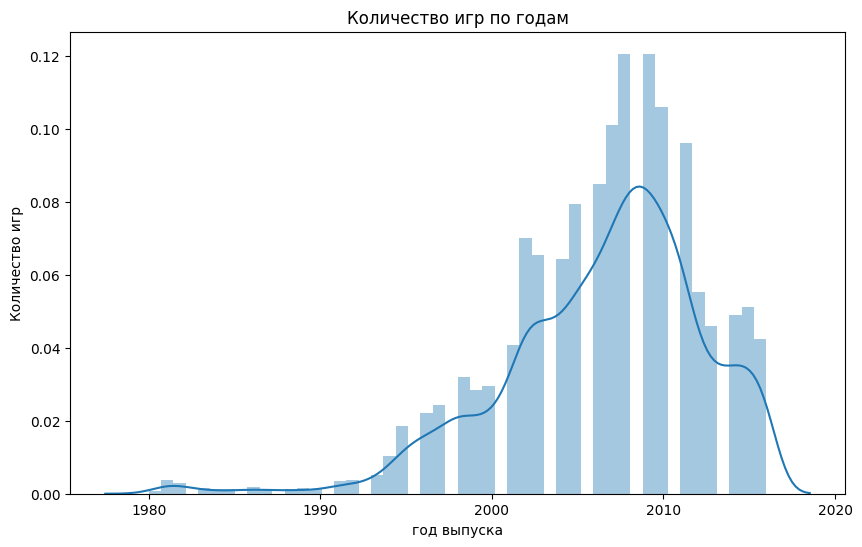

In [20]:
plt.figure(figsize=(10,6))

sns.distplot(games_year_filter['year_of_release']).set_xlabel('год выпуска')
plt.ylabel('Количество игр')
plt.title('Количество игр по годам')

**Комментарий:**

Пик выпуска игр пришелся на 2008-2010 годы. Основная масса игр производилась в период с 2003 до 2011 год. Далее мы наблюдаем спад в этой индустрии. После застоя 2012-2014 мы снова наблюдаем скачок вверх. Думаю, что игры с 1980 по 2003 годы можно не брать во внимание, слишком малое количество было произведено, вряд ли мы сможем сделать хороший прогноз, если включим в исследование старые игры. В целом если говорить о графике, распределение похоже на нормальное.
Можно проанализировать, какие игры произовдились на пике (жанры), нужно понять, с чем это было связано. Возможно, в эти годы появились новые жанры, поэтому новых игр было так много. Также нужно понять, какие жанры начали производить в конце 2014 года (может, скачок связан не только с жанром, но и с платформой).

**Задача 2** 
<br>Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [21]:
#так как мы определили, что нам наиболее интересно рассматривать игры с 2003 года
#сделаем срез по году

games_since2003 = games_year_filter.query('year_of_release >= 2003')

In [22]:
#далее продолжу работать с отфильтрованной таблицей

games_since2003['platform'].value_counts().sort_values(ascending=False)

DS      2120
PS2     1580
PS3     1306
Wii     1286
X360    1232
PSP     1193
PC       876
XB       611
3DS      512
GBA      505
PSV      429
PS4      392
GC       368
XOne     247
WiiU     147
PS         3
DC         2
Name: platform, dtype: int64

**Комментарий:**
<br>С первого взгляда можно сказать, что платформ довольно много, самыми популярными являются PS3, PS2 и DS. Самыми непопулярными платформами стали PS и DC.

In [23]:
# сделаем таблицу, в которой сведем продажи по каждой платформе по годам

games2003_filter = games_since2003.pivot_table(index=['platform', 'year_of_release'], values=['total_game_sale'], aggfunc={'total_game_sale':'sum'}).reset_index()
games2003_filter.columns = games2003_filter.columns.get_level_values(0)
games2003_filter = games2003_filter.set_axis(['platform', 'year_of_release', 'total_sales'], axis=1, inplace=False)
games2003_filter

,platform,year_of_release,total_sales
0,3DS,2011,63.20
1,3DS,2012,51.36
2,3DS,2013,56.57
3,3DS,2014,43.76
4,3DS,2015,27.78
...,...,...,...
118,XB,2008,0.18
119,XOne,2013,18.96
120,XOne,2014,54.07
121,XOne,2015,60.14


In [24]:
#определим топ-5 платформ с суммарными большими продажами

top_platforms = games2003_filter.groupby('platform')['total_sales'].sum().sort_values(ascending=False)[:5]
top_platforms

platform
X360    961.24
PS3     931.34
Wii     891.18
PS2     822.58
DS      802.76
Name: total_sales, dtype: float64

In [25]:
# сделаем отдельную таблицу для построения графика

top5 = ['X360', 'PS3', 'Wii', 'PS2', 'DS']
top5_platforms = games2003_filter.query('platform==@top5').copy()

Text(0, 0.5, 'Количество игр, млн.')

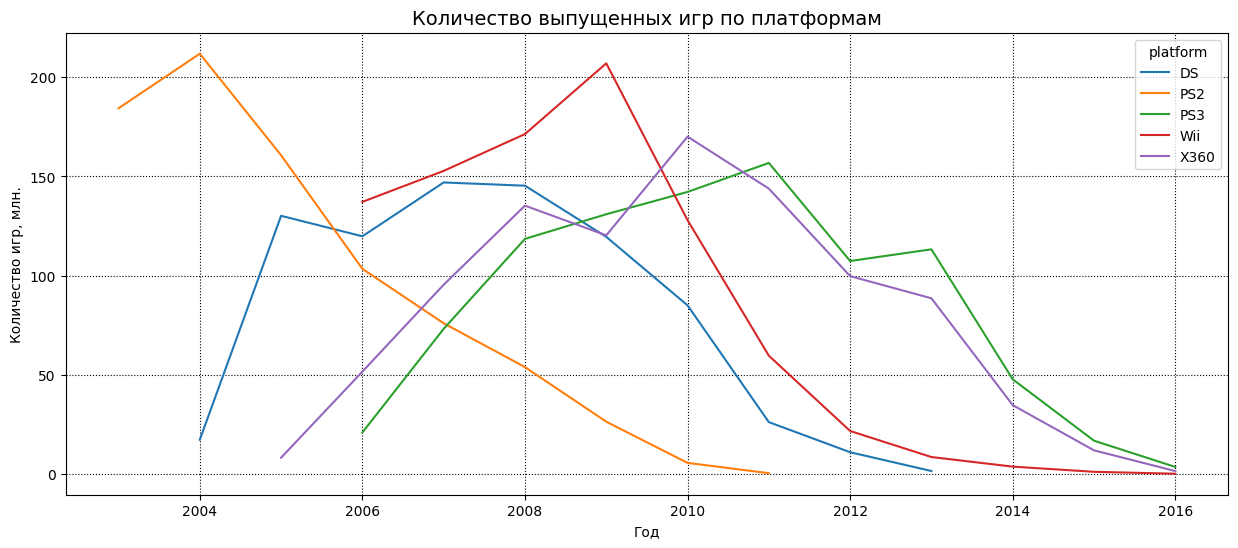

In [26]:
rcParams['figure.figsize'] = 15,6
pd.pivot_table(top5_platforms.reset_index(), index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').plot(legend=True)

plt.grid(True, color='k', linestyle=':')
plt.title('Количество выпущенных игр по платформам', size=14)
plt.xlabel('Год')
plt.ylabel('Количество игр, млн.')

Как можно судить по графику, то в среднем срок каждой платформы около **10 лет**:

- PS2 6 лет
- DS 8 лет
- PS3 9 лет
- X360 10 лет
- Wii 7 лет

К 2014-2015 годам из топ-5 самых популярных платформ остались только две - X360 и PS3, данные по 2016 году у нас неполные. Можем сделать вывод, что к 2017 должна появиться новая платформа, так как популярность старых уже падает. В 2006 году наблюдаем резкий скачок - появление дополнительных платформ, которые вошли в наш топ-5 список. Начиная с 2010-2011 мы наблюдаем спад в продажах, поэтому для дальнейшего исследования возьмем все данные с 2011 года.

In [27]:
games_since2011 = games_since2003.query('year_of_release >= 2011')

**Задача 3** 
<br>Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

In [28]:
# отберем 5 платформ с наибольшей прибылью с 2011 года

games_since2011.groupby('platform')['total_game_sale'].sum().sort_values(ascending=False)[:5]

platform
PS3     445.57
X360    380.38
PS4     314.14
3DS     257.81
XOne    159.32
Name: total_game_sale, dtype: float64

In [29]:
# сделаем отдельную таблицу для построения графика

top5_since2011 = ['X360', 'PS3', '3DS', 'PS4', 'XOne']
top5_platforms_2011 = games_since2011.query('platform==@top5_since2011').copy()

Text(0, 0.5, 'Количество игр, млн.')

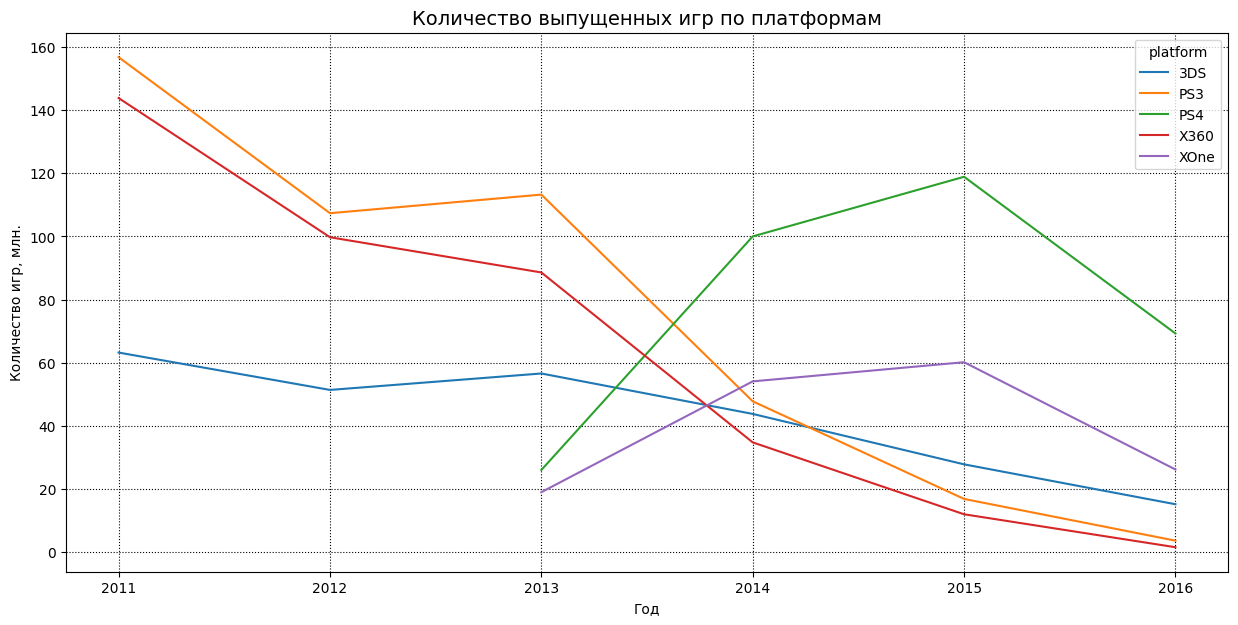

In [30]:
# проанализируем динамику развития платформ с 2011 года

rcParams['figure.figsize'] = 15,7

pd.pivot_table(top5_platforms_2011.reset_index(), index='year_of_release', columns='platform', values='total_game_sale', aggfunc='sum').plot(legend=True)

plt.grid(True, color='k', linestyle=':')
plt.title('Количество выпущенных игр по платформам', size=14)
plt.xlabel('Год')
plt.ylabel('Количество игр, млн.')

**Комментарии к графику:**

1. Платформы PS3 и X360 были на пике в 2011 году, после чего наблюдается спад вплоть до 2013 года. Платформа X360 отстает по показателям, однако их продажи идут практически на одном уровне все годы.
2. Платформа 3DS показывает стабильные продажи с 2011 по 2013 годы, после чего начинает медленно снижаться по показателям. На 2016 год показатели продаж очень близки к показателям продаж платформы XOne.
3. Платформы XOne и PS4 появились в 2013 году, что, вероятно, повлияло на спад продаж по другим платформам. 
4. PS4 показывает большой подъем на старте и вплоть до 2015 года продажи увеличиваются, с 2015 года наблюдается сильный спад, но показатели продаж у этой платформы выше всех на 2016 год.
5. Несмотря на то, что XOne вышла вместе с PS4, ее продажи не пошли так же стремительно вверх. Она показывает умеренный рост до 2015 года, при том ее показатели на 2015 год в 2 раза меньше, чем у PS4 в этот же год. Но тем неменее на 2016 год эта платформа является второй по продажам среди остальных.

**Потенциально прибыльные платформы:**

1. **PS4** - появилась не так давно, если мы говорим, что в среднем срок службы (полезной) платформы составляет 10 лет, то у нас в запасе есть еще как минимум 5 лет.
2. **XOne** - хоть и отстает по продажам от PS4, думаю, что у нее есть хороший потенциал, показатели по продажам по ней на 2 месте.
3. **3DS** - год выпуска 2011, есть время для развития потенциала, учитывая также и тот факт, что на конец 2016 года продажи были наравне с XOne. 

**Задача 4** 
<br>Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

In [31]:
# сделаем отдельную таблицу для тех платформ, которые считаем потенциально прибыльными

profit_platforms = ['3DS', 'PS4', 'XOne']
profit_platforms_since2011 = games_since2011.query('platform==@profit_platforms').copy()

Text(0, 0.5, 'Глобальные продажи (млн.копий)')

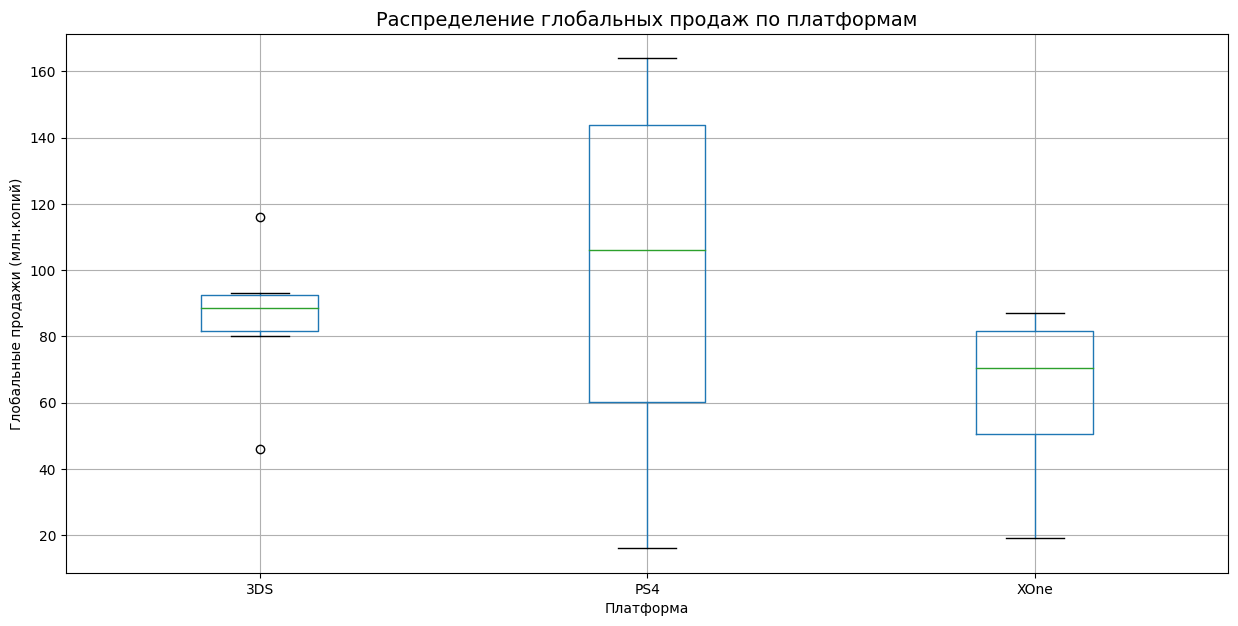

In [32]:
rcParams['figure.figsize'] = 15,7

pd.pivot_table(profit_platforms_since2011.reset_index(), index='year_of_release', columns='platform', values='total_game_sale', aggfunc='count').boxplot()

plt.grid(True)
plt.title('Распределение глобальных продаж по платформам', size=14)
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи (млн.копий)')

**Вывод по графику:**
<br> Продажи по платформе 3DS выглядят наиболее стабильными - разброс значений незначительный, однако наблюдается два выбивающихся значения. Платформа XOne имеет гораздо больший разброс, но по количеству достаточно близко к 3DS. Продажи по платформе PS4 самые большие, но и размах значений тоже достаточно большой и колеблется от 18 до 160, что, на мой взгляд, выглядит достаточно странно. Однако, исходя из предыдущего графика, мы видим, что продажи по платформе достаточно быстро росли и вышли в большой пик, больший, чем у остальных платформ.

**Задача 5** 
<br>Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
Соотнесите выводы с продажами игр на других платформах.

In [33]:
#в качетсве объекта исследования я хочу взять платформу XOne

one = games_since2011.query('platform == "XOne" & total_game_sale != 0 & critic_score != 0 & user_score != 0')

In [34]:
table_for_one = one.pivot_table(index='platform', values=['total_game_sale', 'critic_score', 'user_score'])
table_for_one

,critic_score,total_game_sale,user_score
platform,,,
XOne,49.854251,0.64502,4.542105


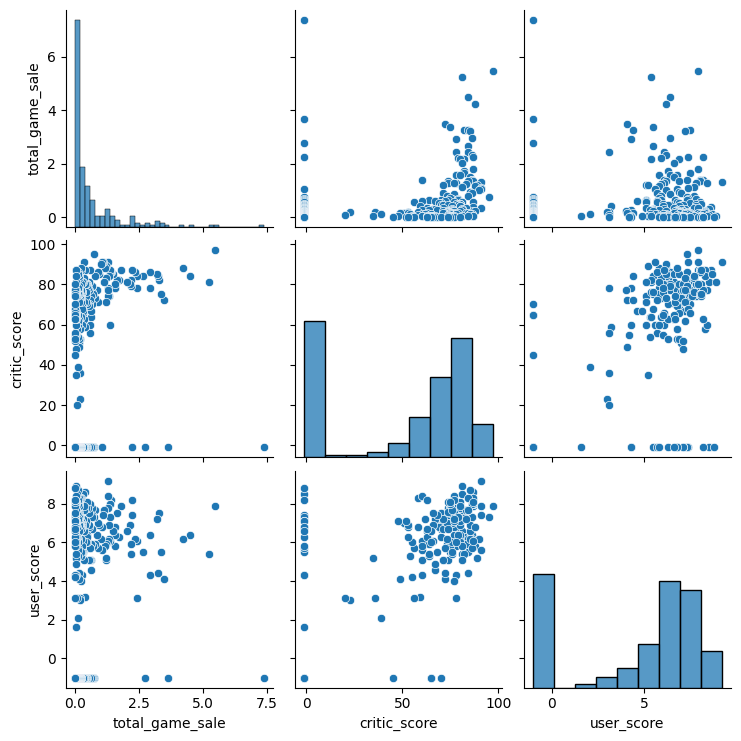

In [35]:
rcParams['figure.figsize'] = 15,7

sns.pairplot(one[['total_game_sale', 'critic_score', 'user_score']])

plt.grid(True)

In [36]:
focus_cols = ['critic_score', 'user_score']
one.corr().filter(focus_cols).drop(focus_cols)

,critic_score,user_score
year_of_release,-0.008564,-0.004957
na_sales,0.258757,0.117853
eu_sales,0.258374,0.109855
jp_sales,0.149336,0.088582
other_sales,0.268987,0.118898
total_game_sale,0.273782,0.121712


**Комментарий:**
<br>Безусловно оценка критиков и пользователей имеют влияние на продажи. Однако, оценки критиков имеют большую корреляцию, что говорит нам о том, что продажи больше зависят от этого показателя. 
<br>**Общий вывод** - продажи любой платформы зависят от оценок, но, предполагаю, что покупатели все-таки большее внимание уделяют оценкам критиков, так как, видимо, считают их более объективными и опытными, нежели оценкам пользователей. Существенная разница между показателями корреляции есть.

**Задача 6** 
<br>Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [37]:
#посмотрим на общее распределение игр по жанрам

games_genre = games_since2011.pivot_table(index='genre', values='total_game_sale', aggfunc='count')
games_genre.reset_index(inplace=True)
#games_genre_top5 = games_genre.sort_values(by='total_game_sale', ascending=False)[:5]

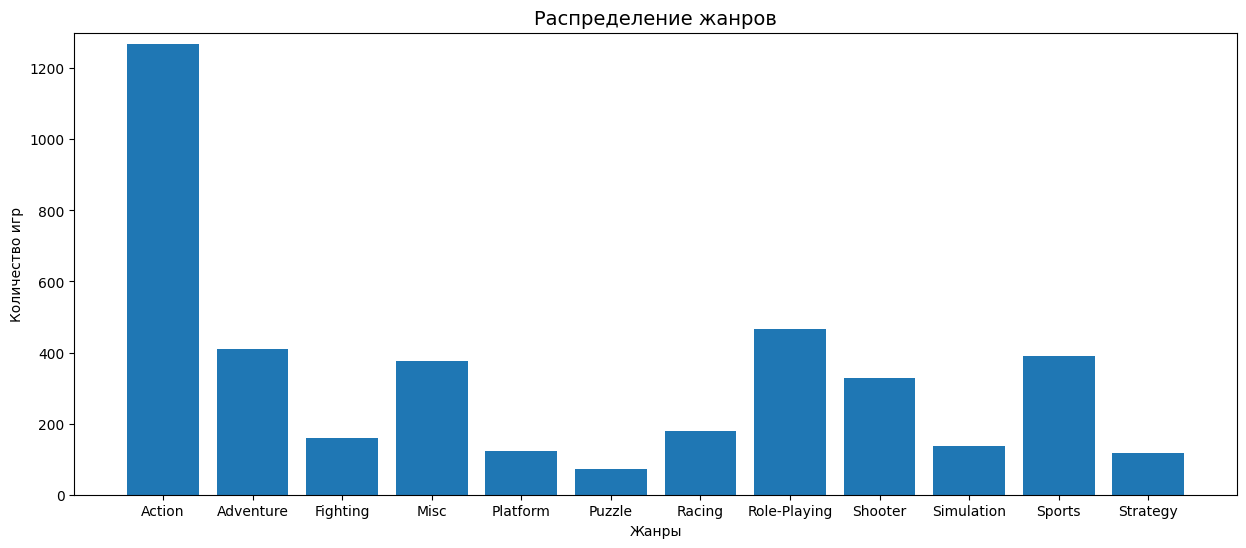

In [38]:
rcParams['figure.figsize'] = 15,6

plt.bar(games_genre['genre'], games_genre['total_game_sale'])

plt.title('Распределение жанров', fontsize=14)
plt.xlabel('Жанры')
plt.ylabel('Количество игр')
plt.ylim(0,1300)
plt.show()

In [39]:
games_genre['%'] = games_genre['total_game_sale'] / games_genre['total_game_sale'].sum() * 100
games_genre.sort_values('%', ascending=False)

,genre,total_game_sale,%
0,Action,1269,31.551467
7,Role-Playing,465,11.561412
1,Adventure,410,10.193933
10,Sports,389,9.671805
3,Misc,375,9.323720
8,Shooter,329,8.180010
6,Racing,180,4.475385
2,Fighting,159,3.953257
9,Simulation,136,3.381402
4,Platform,122,3.033317


In [40]:
#выделим из жанров самые прибыльные

top_genre = games_since2011.pivot_table(index='genre', values='total_game_sale', aggfunc='sum')
top_genre.reset_index(inplace=True)
#final_top_genre = top_genre.sort_values(by='total_game_sale', ascending=False)[:5]

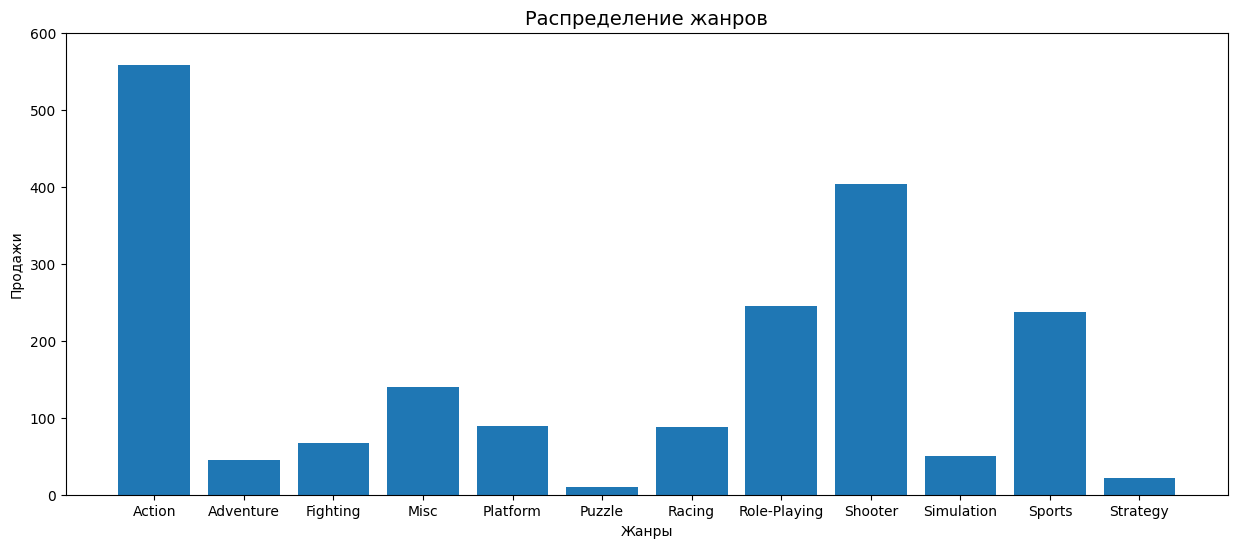

In [41]:
rcParams['figure.figsize'] = 15,6

plt.bar(top_genre['genre'], top_genre['total_game_sale'])

plt.title('Распределение жанров', size=14)
plt.xlabel('Жанры')
plt.ylabel('Продажи')
plt.ylim(0,600)
plt.show()

In [42]:
top_genre['%'] = top_genre['total_game_sale'] / top_genre['total_game_sale'].sum() * 100
top_genre.sort_values('%', ascending=False)

,genre,total_game_sale,%
0,Action,557.80,28.544964
8,Shooter,402.91,20.618594
7,Role-Playing,245.63,12.569917
10,Sports,237.15,12.135960
3,Misc,139.42,7.134706
4,Platform,88.68,4.538127
6,Racing,88.31,4.519193
2,Fighting,66.90,3.423553
9,Simulation,50.26,2.572015
1,Adventure,45.04,2.304886


**У нас получилось интересное распределение, вот какие выводы можно сделать:**

1. Наибольшее количество игр в жанре "Action" (31%), причем с большим отрывом, также этот жанр является самыми прибыльным.
2. Примерно на одном уровне по популярности - "Role-Playing", "Adventure", "Sports", "Misc", "Shooter". 
3. Несмотря на то, что игры в жанре "Shooter" имеют долю всего лишь 8% по популярности, по прибыльности они на втором месте и от общей доли имеют 12%.
4. Игры жанров "Simulation", "Strategy", "Puzzle" находятся на одном примерно уровне и по популярности, и по прибыльности.
5. Интересно, что игры в жанре "Adventure" занимают третьей место по популярности, а по прибыльности они на предпоследнем месте с долей 1,1%.

## Портреты пользователя для каждого региона

Определите для пользователя каждого региона (NA, EU, JP):
* 		Самые популярные платформы (топ-5). Опишите различия в долях продаж.
* 		Самые популярные жанры (топ-5). Поясните разницу.
* 		Влияет ли рейтинг ESRB на продажи в отдельном регионе?

### Подготовка данных для анализа

#### Северная Америка

In [43]:
#популярные платформы

region_na_platforms = games_since2011.pivot_table(index='platform', values='na_sales', aggfunc=['sum'])
region_na_platforms.reset_index(inplace=True)
region_na_platforms.columns = ['platform', 'sum_sales']
region_na_platforms1 = region_na_platforms.sort_values(by='sum_sales', ascending=False)[:5]
region_na_platforms1['%'] = region_na_platforms1['sum_sales'] / region_na_platforms1['sum_sales'].sum() * 100
region_na_platforms1

,platform,sum_sales,%
10,X360,226.80,33.374045
4,PS3,168.26,24.759775
5,PS4,108.74,16.001295
11,XOne,93.12,13.702783
0,3DS,82.65,12.162103


In [44]:
#популярные жанры

region_na_genre = games_since2011.pivot_table(index='genre', values='na_sales', aggfunc=['sum'])
region_na_genre.reset_index(inplace=True)
region_na_genre.columns = ['genre','sum_sales']
region_na_genre1 = region_na_genre.sort_values(by='sum_sales', ascending=False)[:5]
region_na_genre1['%'] = region_na_genre1['sum_sales'] / region_na_genre1['sum_sales'].sum() * 100
region_na_genre1

,genre,sum_sales,%
0,Action,230.92,33.587387
8,Shooter,194.43,28.279905
10,Sports,108.70,15.810449
7,Role-Playing,83.78,12.185827
3,Misc,69.69,10.136432


In [45]:
#посмотрим на влияние рейтинга ESRB

region_na_rating = games_since2011.pivot_table(index='rating', values='na_sales', aggfunc=['sum'])
region_na_rating.reset_index(inplace=True)
region_na_rating.columns = ['rating','sum_sales']
region_na_rating1 = region_na_rating.sort_values(by='sum_sales', ascending=False)[:5]
region_na_rating1['%'] = region_na_rating1['sum_sales'] / region_na_rating1['sum_sales'].sum() * 100
region_na_rating1

,rating,sum_sales,%
3,M,308.45,37.192225
0,E,170.17,20.518726
6,unknown,123.69,14.914269
1,E10+,117.72,14.194420
5,T,109.31,13.180360


**Портрет пользователя из Северной Америки:**
- В Северной Америке, как и во всем мире, самым полуярным жанром является "Action". В целом топ-5 жанров в Северной Америке схожи с топ-5 во всем мире. Однако, популярный жанр "Role-Playing" (второе место по популярности в мире) занимает только 4 место.
- Самые продаваемые игры в Северной Америке - игры для взрослых (старше 17 лет), далее идут игры для всех. Достаточно большую долю имеет категория "unknown", к сожалению, если бы не было так много пропусков, картина в целом могла бы быть другой. Интересно, что достаточно большая разница между играми для всех и играми 10+ лет. Возможно, это означает, что либо американцы не придают значения (или не видят разницу) возрастному ограничению в играх подобного рейтинга, либо в Северной Америке довольно большое количество игр покупается именно для детей младше 10 лет.
- Интересно, что большую часть популярных жанров занимают игры жанра "Shooter" (28%), а на втором по популярности месте по рейтингам - игры для всех. Думаю, что действительно, если бы было меньше пропусков в данных, то мы бы увидели другую картину. 
- Американцы предпочитают в основном играть на платформе X360. Вторая по популярности платформа PS3, платформа PS4 отстает не намного. Думаю, что в ближайшем будущем PS4 займет второе место. Так как данные взяты с 2011 года, а PS4 появилась только в 2013 году, то на данный момент это уже отличный результат.

#### Европа

In [46]:
#популярные платформы

region_eu_platforms = games_since2011.pivot_table(index='platform', values='eu_sales', aggfunc=['sum'])
region_eu_platforms.reset_index(inplace=True)
region_eu_platforms.columns = ['platform', 'sum_sales']
region_eu_platforms1 = region_eu_platforms.sort_values(by='sum_sales', ascending=False)[:5]
region_eu_platforms1['%'] = region_eu_platforms1['sum_sales'] / region_eu_platforms1['sum_sales'].sum() * 100
region_eu_platforms1

,platform,sum_sales,%
4,PS3,163.10,30.245151
5,PS4,141.09,26.163632
10,X360,117.10,21.714943
0,3DS,61.27,11.361866
2,PC,56.70,10.514409


In [47]:
#популярные жанры

region_eu_genre = games_since2011.pivot_table(index='genre', values='eu_sales', aggfunc=['sum'])
region_eu_genre.reset_index(inplace=True)
region_eu_genre.columns = ['genre','sum_sales']
region_eu_genre1 = region_eu_genre.sort_values(by='sum_sales', ascending=False)[:5]
region_eu_genre1['%'] = region_eu_genre1['sum_sales'] / region_eu_genre1['sum_sales'].sum() * 100
region_eu_genre1

,genre,sum_sales,%
0,Action,199.12,36.976787
8,Shooter,148.02,27.487465
10,Sports,88.48,16.430826
7,Role-Playing,62.30,11.569174
6,Racing,40.58,7.535747


In [48]:
#посмотрим на влияние рейтинга ESRB

region_eu_rating = games_since2011.pivot_table(index='rating', values='eu_sales', aggfunc=['sum'])
region_eu_rating.reset_index(inplace=True)
region_eu_rating.columns = ['rating','sum_sales']
region_eu_rating1 = region_eu_rating.sort_values(by='sum_sales', ascending=False)[:5]
region_eu_rating1['%'] = region_eu_rating1['sum_sales'] / region_eu_rating1['sum_sales'].sum() * 100
region_eu_rating1

,rating,sum_sales,%
3,M,250.26,37.365624
0,E,141.73,21.161312
6,unknown,116.61,17.410714
5,T,83.16,12.416388
1,E10+,78.00,11.645963


**Портрет пользователя из Европы**

- В Европе платформы PS3 и PS4 самые популярные, количество пользователей по ним примерно одинаковое, платформа PS4 быстро набрала популярность (по сравнению с Северной Америкой), и судя по тенденции, то и продолжит набирать. Интересно, что в Европе платформа XOne не входит в топ-5, вместо нее в топ попала 3DS.
- Европейцы предпочитают те же жанры игры, как и американцы, за исключением последней позиции в топ-5 - "Racing". 
- По рейтингу картина также очень похожа на Северную Америку.
- В целом можно сказать, что европейцы меньше играют в игры. В Америке показатели по количеству пользователей намного выше.

#### Япония

In [49]:
#популярные платформы

region_jp_platforms = games_since2011.pivot_table(index='platform', values='jp_sales', aggfunc=['sum'])
region_jp_platforms.reset_index(inplace=True)
region_jp_platforms.columns = ['platform', 'sum_sales']
region_jp_platforms1 = region_jp_platforms.sort_values(by='sum_sales', ascending=False)[:5]
region_jp_platforms1['%'] = region_jp_platforms1['sum_sales'] / region_jp_platforms1['sum_sales'].sum() * 100
region_jp_platforms1

,platform,sum_sales,%
0,3DS,100.62,47.495870
4,PS3,49.39,23.313665
6,PSP,24.04,11.347652
7,PSV,21.84,10.309181
5,PS4,15.96,7.533632


In [50]:
#популярные жанры

region_jp_genre = games_since2011.pivot_table(index='genre', values='jp_sales', aggfunc=['sum'])
region_jp_genre.reset_index(inplace=True)
region_jp_genre.columns = ['genre','sum_sales']
region_jp_genre1 = region_jp_genre.sort_values(by='sum_sales', ascending=False)[:5]
region_jp_genre1['%'] = region_jp_genre1['sum_sales'] / region_jp_genre1['sum_sales'].sum() * 100
region_jp_genre1

,genre,sum_sales,%
7,Role-Playing,79.87,43.033405
0,Action,63.62,34.278017
3,Misc,17.60,9.482759
2,Fighting,12.38,6.670259
4,Platform,12.13,6.535560


In [51]:
#посмотрим на влияние рейтинга ESRB

region_jp_rating = games_since2011.pivot_table(index='rating', values='jp_sales', aggfunc=['sum'])
region_jp_rating.reset_index(inplace=True)
region_jp_rating.columns = ['rating','sum_sales']
region_jp_rating1 = region_jp_rating.sort_values(by='sum_sales', ascending=False)[:5]
region_jp_rating1['%'] = region_jp_rating1['sum_sales'] / region_jp_rating1['sum_sales'].sum() * 100
region_jp_rating1

,rating,sum_sales,%
6,unknown,138.21,56.262976
0,E,36.68,14.931814
5,T,33.39,13.592510
3,M,26.14,10.641156
1,E10+,11.23,4.571545


**Портрет пользователя из Японии**

- В Японии картина сильно отличается от других регионов. Так, например, наиболее популярная платформа - 3DS, которая в Америке вообще не входит в топ-5. Такая популярная PS4, которая набирает обороты популярности в Европе и Америке, в Японии на последнем месте в топ-5. PSP и PSV находятся примерно на одном уровне по количеству пользователей, хотя в остальных регионах их нет в топ-5.
- Топ жанров тоже сильно отличается. На первом месте игры жанра "Role-Playing", на втором - "Action". Они находятся примерно на одном уровне. Также в Японии в топ попал жанр "Fighting", он занимает 4 позицию.
- Самая большая доля игр - больше половины, к сожалению, с неопознанным рейтингом, далее идут игры с рейтингом для всех. А вот игры с рейтингом для взрослых (старше 17 лет) занимают только 4 место, когда в Америке и Европе они находятся на первых местах.
- В целом Япония является самой малочисленной по количеству игроков страной. Вероятно, из-за того, что в этом регионе так мало пользователей, в топе платформ оказались старые платформы. Также, можно сделать вывод, что большинство пользователей играют в нейтральные игры с общим рейтингом.

### Визуализация результатов и анализ

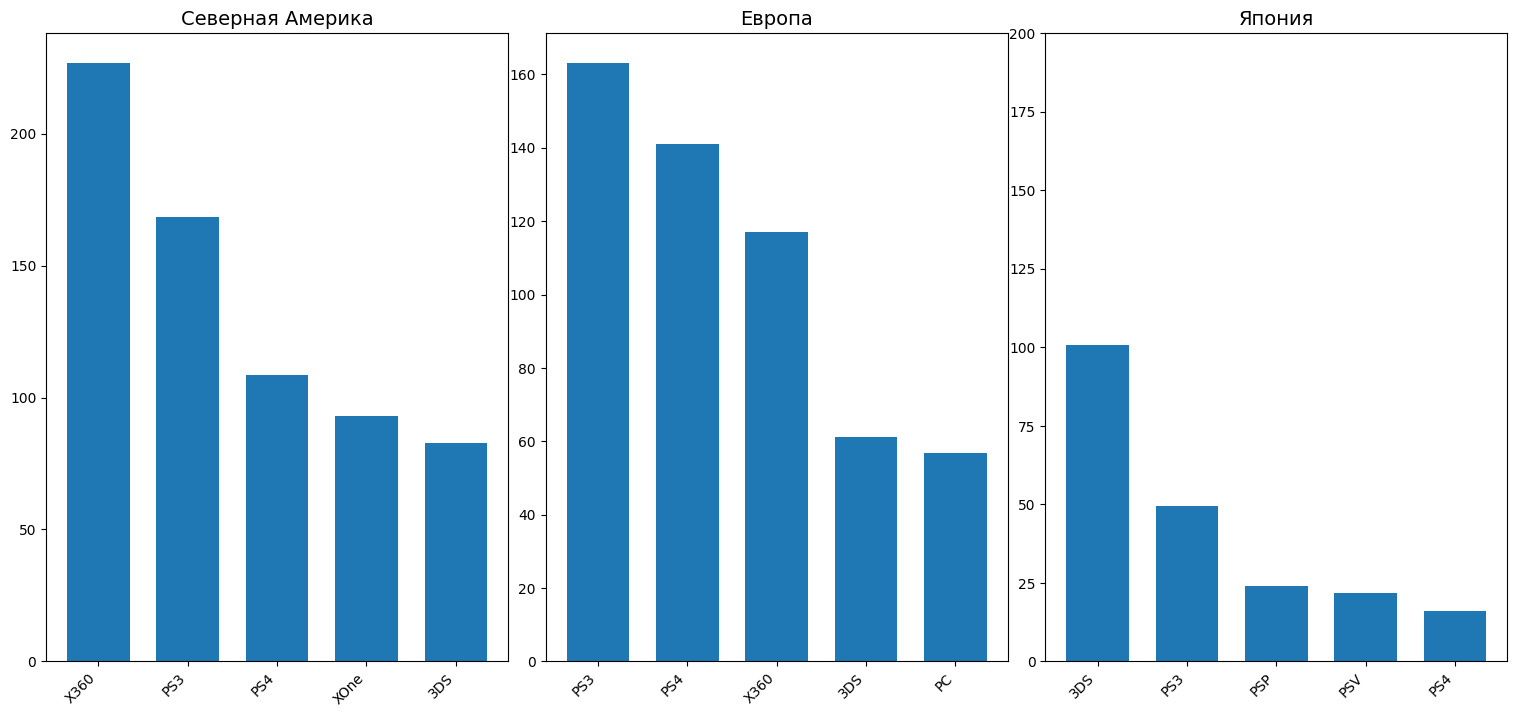

In [52]:
#сравним данные по регионам по топ-5 платформам

fig = plt.figure(figsize=(15,7))

plt.subplot(1, 3, 1)
plt.title('Северная Америка', size=14)
plt.xticks(rotation = 45, horizontalalignment = 'right')
plt.bar(region_na_platforms1['platform'], region_na_platforms1['sum_sales'], width = 0.70)


plt.subplot(1, 3, 2)
plt.title('Европа', size=14)
plt.xticks(rotation = 45, horizontalalignment = 'right')
plt.bar(region_eu_platforms1['platform'], region_eu_platforms1['sum_sales'], width = 0.70)

plt.subplot(1, 3, 3)
plt.title('Япония', size=14)
plt.xticks(rotation = 45, horizontalalignment = 'right')
plt.bar(region_jp_platforms1['platform'], region_jp_platforms1['sum_sales'], width = 0.70)

plt.tight_layout(pad=0.1)
plt.ylim(0,200)
plt.show()

In [53]:
display('Северная Америка', region_na_platforms1)
print()
display('Европа', region_eu_platforms1)
print()
display('Япония', region_jp_platforms1)

'Северная Америка'

,platform,sum_sales,%
10,X360,226.80,33.374045
4,PS3,168.26,24.759775
5,PS4,108.74,16.001295
11,XOne,93.12,13.702783
0,3DS,82.65,12.162103


'Европа'

,platform,sum_sales,%
4,PS3,163.10,30.245151
5,PS4,141.09,26.163632
10,X360,117.10,21.714943
0,3DS,61.27,11.361866
2,PC,56.70,10.514409


'Япония'

,platform,sum_sales,%
0,3DS,100.62,47.495870
4,PS3,49.39,23.313665
6,PSP,24.04,11.347652
7,PSV,21.84,10.309181
5,PS4,15.96,7.533632


**Топ-5 популярных платформ в Северной Америке:**

<br>Платформа X360 с большим отрывом на первом месте, доля продаж по платформе составляет 33%. Интересно, что эта платформа самая популярная только в Северной Америке, продажи по ней в Америке выше на 109 млн., чем в Европе, а в Японии она не входит в топ-5. Вторая по популярности является PS3, следующие платформы уже сильно отстают по продажам. В целом можно сказать, что для Северной Америки абсолютно нетипично иметь платформу XB, PSV, DC, GC, GBA, PSP - вероятно, это отголоски прошлого, люди по старой памяти иногда могут во что-то на них играть. Доли продаж по этим платформам абсолютно минимальны.

**Топ-5 популярных платформ в Европе:**

<br>В отличие от Северной Америки в Европе самой популярной платформой является PS3, хотя продажи по ней в Европе ниже, чем в Америке, но это связано с тем, что в Европе гораздо меньше пользователей. На втором месте платформа PS4, продажи по ней в Европе гораздо выше, чем в Северной Америке, а вот платформа X360, которая в Америке на первом месте, в Европе имеет показатели продаж гораздо ниже.
Самыми непопулярными платформами являются - XB, PSV, GC, GBA, DC, WiiU, PS2. Я бы не делала ставки на них и не продвигала бы игры в Европе, которые работают на этих платформах.


**Топ-5 популярных платформ в Японии:**

<br>По сравнению с другими регионами в Японии меньше всего продаж игр, также довольно мало платформ, на которых играют пользователи - всего 7. Отсюда и высокие доли продаж по платформам из списка топ-5. Возможно, это связано с тем, что в Японии могут быть свои платформы и свои игры, которые не попали в наш датасет. Также предполагаю, что в Японии из-за того, что нечасто играют, то и необходимость в покупке новых платформ отсутствует.

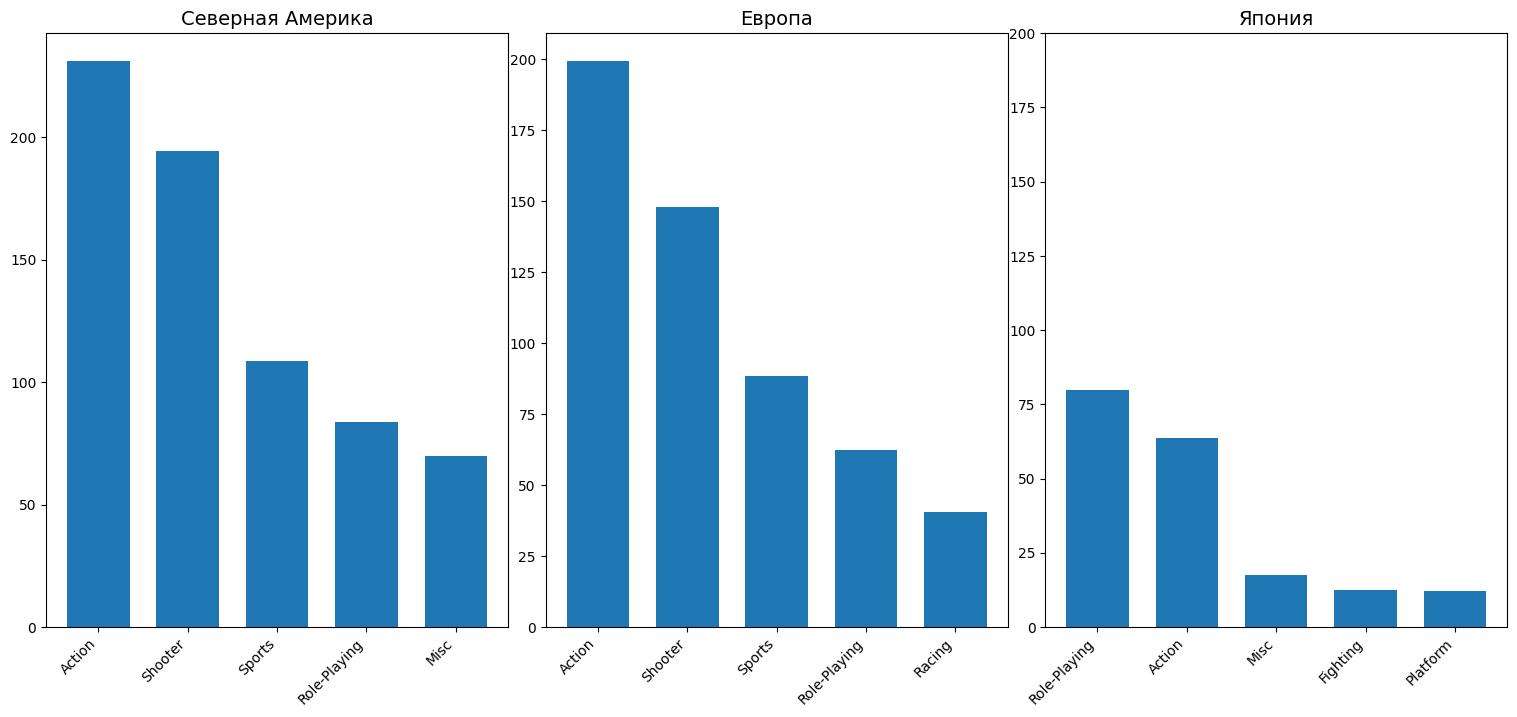

In [54]:
#сравним данные по регионам по топ-5 жанрам 

fig = plt.figure(figsize=(15,7))

plt.subplot(1, 3, 1)
plt.title('Северная Америка', size=14)
plt.xticks(rotation = 45, horizontalalignment = 'right')
plt.bar(region_na_genre1['genre'], region_na_genre1['sum_sales'], width = 0.70)

plt.subplot(1, 3, 2)
plt.title('Европа', size=14)
plt.xticks(rotation = 45, horizontalalignment = 'right')
plt.bar(region_eu_genre1['genre'], region_eu_genre1['sum_sales'], width = 0.70)

plt.subplot(1, 3, 3)
plt.title('Япония', size=14)
plt.xticks(rotation = 45, horizontalalignment = 'right')
plt.bar(region_jp_genre1['genre'], region_jp_genre1['sum_sales'], width = 0.70)

plt.tight_layout(pad=0.1)
plt.ylim(0,200)
plt.show()

In [55]:
display('Северная Америка', region_na_genre1)
print()
display('Европа', region_eu_genre1)
print()
display('Япония', region_jp_genre1)

'Северная Америка'

,genre,sum_sales,%
0,Action,230.92,33.587387
8,Shooter,194.43,28.279905
10,Sports,108.70,15.810449
7,Role-Playing,83.78,12.185827
3,Misc,69.69,10.136432


'Европа'

,genre,sum_sales,%
0,Action,199.12,36.976787
8,Shooter,148.02,27.487465
10,Sports,88.48,16.430826
7,Role-Playing,62.30,11.569174
6,Racing,40.58,7.535747


'Япония'

,genre,sum_sales,%
7,Role-Playing,79.87,43.033405
0,Action,63.62,34.278017
3,Misc,17.60,9.482759
2,Fighting,12.38,6.670259
4,Platform,12.13,6.535560


**Топ-5 популярных жанров в Северной Америке:**

<br>С большим отрывом игры в жанре "Action" занимают 1 место в рейтинге по популярности в Северной Америке - 230 млн.продаж. Игры жанров "Shooter" (194 млн.продаж) также имеют достаточно сильный отрыв от прочих игр. Наименьшей популярностью пользуются игры в жанре "Strategy", "Puzzle" и "Adventure". Возможно, популярность этих жанров напрямую связана с игровыми платформами.

**Топ-5 популярных жанров в Европе:**

<br>Безоговорочное первое место достается играм в жанре "Action" (почти 200 млн.продаж). Далее игры жанров "Shooter" (148 млн.продаж) и "Sports", который уже достаточно сильно отстает и имеет всего лишь 88 млн.продаж. В целом распредение топ-5 похожее, как и в Северной Америке, однако на 5 месте появляется жанр Racing.
Самые непопулярные игры жанров - Strategy, Adventure, Fighting и Puzzle. Здесь также картина очень похожа на ситуацию в Северной Америке. В целом можно сказать, что продажи игр в Европе не так высоки (по крайней мере меньше, чем в Северной Америке).

**Топ-5 популярных жанров в Японии:**

<br>Топ-5 в Японии сильно отличается от других регионов, так, например, у нас появился жанры "Platform" и "Fighting", которые не вошли в топы по Северной Америке и Европе. Самый популярный жанр "Role-Playing" - число продаж 80 млн. Можно сделать вывод, что практически половина всех игроков в Японии предпочитают игры жанра "Role-Playing". Также интересно, что "стрелялки" (Shooter) практически не пользуются популярностью, в отличие от других регионов.

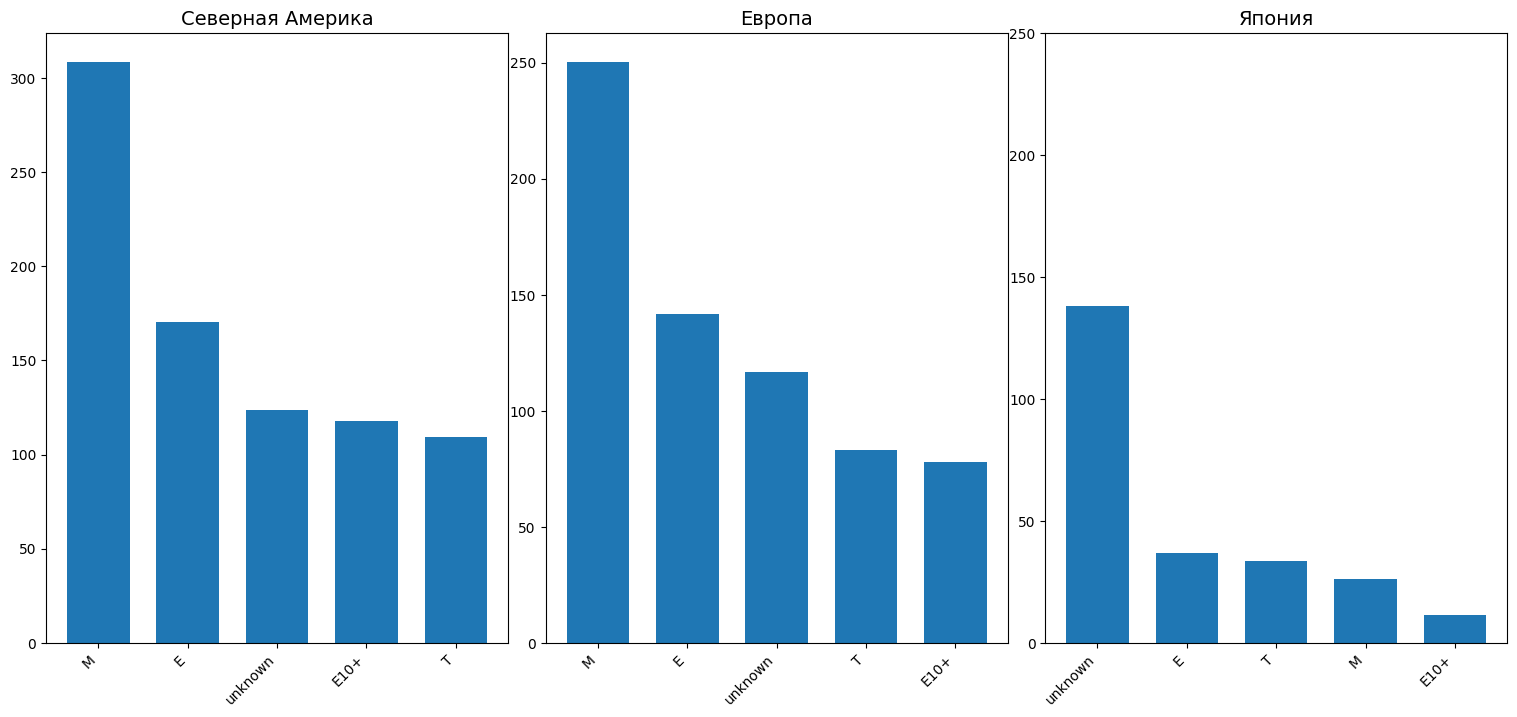

In [56]:
#сравним данные по регионам по топ-5 рейтингам ESRB

fig = plt.figure(figsize=(15,7))

plt.subplot(1, 3, 1)
plt.title('Северная Америка', size=14)
plt.xticks(rotation = 45, horizontalalignment = 'right')
plt.bar(region_na_rating1['rating'], region_na_rating1['sum_sales'], width = 0.70)

plt.subplot(1, 3, 2)
plt.title('Европа', size=14)
plt.xticks(rotation = 45, horizontalalignment = 'right')
plt.bar(region_eu_rating1['rating'], region_eu_rating1['sum_sales'], width = 0.70)

plt.subplot(1, 3, 3)
plt.title('Япония', size=14)
plt.xticks(rotation = 45, horizontalalignment = 'right')
plt.bar(region_jp_rating1['rating'], region_jp_rating1['sum_sales'], width = 0.70)

plt.tight_layout(pad=0.1)
plt.ylim(0,250)
plt.show()

In [57]:
display('Северная Америка', region_na_rating1)
print()
display('Европа', region_eu_rating1)
print()
display('Япония', region_jp_rating1)

'Северная Америка'

,rating,sum_sales,%
3,M,308.45,37.192225
0,E,170.17,20.518726
6,unknown,123.69,14.914269
1,E10+,117.72,14.194420
5,T,109.31,13.180360


'Европа'

,rating,sum_sales,%
3,M,250.26,37.365624
0,E,141.73,21.161312
6,unknown,116.61,17.410714
5,T,83.16,12.416388
1,E10+,78.00,11.645963


'Япония'

,rating,sum_sales,%
6,unknown,138.21,56.262976
0,E,36.68,14.931814
5,T,33.39,13.592510
3,M,26.14,10.641156
1,E10+,11.23,4.571545


**Расшифровка рейтингов:**

- ***«EC» («Early childhood»)*** — «Для детей младшего возраста»
- ***«E» («Everyone»)*** — «Для всех»
- ***«E10+» («Everyone 10 and older»)*** — «Для всех от 10 лет и старше»
- ***«T» («Teen»)*** — «Подросткам»
- ***«M» («Mature»)*** — «Для взрослых»
- ***«RP» («Rating Pending»)*** — «Рейтинг ожидается»

**Топ-5 игр с рейтингами ESRB в Северной Америке:**

<br>В Северной Америке пользователи в основном предпочитают покупать игры "для взрослых", у них очень большой количественный отрыв. На втором месте игры "для всех". Интересно, что игры с рейтингом RP практически не покупаются вовсе.

**Топ-5 игр с рейтингами ESRB в Европе:**

<br>В Европе картина несущественно отличается. На первом месте так же с большим отрывом игры "для взрослых", далее идут игры "для всех". Интересно, что в Европе гораздо меньше покупают игры "для всех от 10 лет и старше" и покупают игры с рейтингом RP.

**Топ-5 игр с рейтингами ESRB в Японии:**

<br>В Японии первое место занимают игры с неопознанным рейтингом (там, конечно, наверняка перемешаны все данные). Интересно, что такие популярные в других регионах игры "для взрослых" всего лишь на 3 месте топа. Как и в других регионах на втором месте игры с рейтингом "для всех" - везде игры этого рейтинга пользуются большой популярностью.

### Выводы

**Портрет пользователя из Северной Америки**

1. У типичного пользователя из этого региона будет установлена какая-либо из платформ ниже, а, возможно, у кого-то даже будет несколько платформ:
* X360
* PS3
* PS4
* XOne
* 3DS

2. Вероятнее всего пользователь из Северной Америки будет преимущественно играть в игры жанров - Shooter, Action, Sports, Misc, Role-Playing
3. Если игра в магазине будет без какого-либо рейтинга ESRB (или будет в режиме ожидания рейтинга), вероятнее всего, игра не будет куплена. В Северной Америке в основном покупают игры "для всех" и "для взрослых". 

**Портрет пользователя из Европы**

1. Пользоватаели в Европе предпочитают играть на платформах PS4 и PS3.
2. Люди в Европе меньше играют в видео-игры, чем в Северной Америке.
3. Пользователи в Европе предпочитают играть в игры жанра "Racing", по остальным жанрам пользователи из Европы схожи с пользователями из Северной Америки.
4. Так же как и в Северной Америке, в Европе люди предпочитают не покупать игры без рейтинга ESRB (либо те игры, которые находятся в процессе проверки). 
5. Пользователи в Европе в основном покупают игры "для всех" и "для взрослых".

**Портрет пользователя из Японии**

1. В Японии игры не так популярны, как в других регионах, пользователей не так много.
2. В основном пользователи играют на платформах 3DS, PS3 и PSP. 
3. Больше половины пользователей в Японии предпочитают игры в жанре "Role-Playing".
4. Жанр "Shooter", популярный в других регионах, в Японии имеет минимальные продажи, а жанр "Fighting" наоборот популярен, что не скажешь о других регионах.
5. В Японии, судя по всему, среди пользователей много подростков, так как доля игр с рейтингом для них составляет 17%.

## Проверка гипотез

### Гипотеза № 1

***Средние пользовательские рейтинги платформ Xbox One и PC одинаковые***

**$H_0$:** Средние пользовательские рейтинги платформы Xbox One равны средним пользовательским рейтингам платформы PC <br>
**$Н_1$:** Средние пользовательские рейтинги платформы Xbox One не равны средним пользовательским рейтингам платформы PC <br>

<br>Уровень значимости я хочу назначить 0,01 - так как у нас достаточно большая выборка, поэтому 5% кажется достаточно большой вероятностью ошибки. Будем делать двусторонний тест.

In [58]:
#подготовим выборки

user_rating_one = games_since2011.query('platform == "XOne"')['user_score']
user_rating_pc = games_since2011.query('platform == "PC"')['user_score']

In [59]:
#сделаем предварительное сравнение дисперсий

variance1 = np.var(user_rating_one)
print('Дисперсия выборки по платформе Xbox One:', variance1)

variance2 = np.var(user_rating_pc)
print('Дисперсия выборки по платформе PC:', variance2)

Дисперсия выборки по платформе Xbox One: 12.36705305774558
Дисперсия выборки по платформе PC: 11.280255086868314


In [60]:
alpha = 0.01

results = st.ttest_ind(
            user_rating_one,
            user_rating_pc,
            nan_policy='omit',
            equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.22953004908742605
Не получилось отвергнуть нулевую гипотезу


In [61]:
#посмотрим на средние значения выборок

games_since2011.pivot_table(
   index='platform', values='user_score', aggfunc='median')

,user_score
platform,
3DS,-1.0
DS,-1.0
PC,6.1
PS2,-1.0
PS3,4.9
PS4,6.1
PSP,-1.0
PSV,-1.0
Wii,-1.0


**Комментарий:**
<br>По итогам теста нам не удалось отвергнуть нулевую гипотезу, так как средние значения по пользовательским рейтингам действительно практически равны друг другу, это мы видим так же и из нашей проверки. Дисперсии выборок также почти равны. Это означает, что обе платформы пользуются одинаковым рейтингом среди пользователей из любого региона.

### Гипотеза № 2

***Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.***

**$H_0$:** Средние пользовательские рейтинги жанра Action равны средним пользовательским рейтингам жанра Sports <br>
**$Н_1$:** Средние пользовательские рейтинги жанра Action не равны средним пользовательским рейтингам жанра Sports <br>

<br>Уровень значимости я хочу назначить 0,01 - так как у нас достаточно большая выборка, поэтому 5% кажется достаточно большой вероятностью ошибки. Будем делать двусторонний тест.

In [62]:
#подготовим выборки

user_rating_action = games_since2011.query('genre == "Action"')['user_score']
user_rating_sports = games_since2011.query('genre == "Sports"')['user_score']

In [63]:
#сделаем предварительное сравнение дисперсий

variance1 = np.var(user_rating_action)
print('Дисперсия выборки с жанром Action:', variance1)

variance2 = np.var(user_rating_sports)
print('Дисперсия выборки с жанром Sports:', variance2)

Дисперсия выборки с жанром Action: 16.03012451245404
Дисперсия выборки с жанром Sports: 12.098499745573974


In [64]:
#так как дисперсии наших выборок отличаются, для параментра equal_var мы выбираем False

alpha = 0.01

results = st.ttest_ind(
            user_rating_action,
            user_rating_sports,
            nan_policy='omit',
            equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.5124327249742402
Не получилось отвергнуть нулевую гипотезу


In [65]:
#посмотрим на средние значения выборок

games_since2011.pivot_table(
    index='genre', values='user_score', aggfunc='median')

,user_score
genre,
Action,3.90
Adventure,-1.00
Fighting,6.20
Misc,-1.00
Platform,6.35
Puzzle,-1.00
Racing,5.10
Role-Playing,-1.00
Shooter,6.20


По итогам теста нам не удалось отвергнуть нулевую гипотезу - средние значения примерно одинаковые, это видно и по значениям дисперсии и медиане. Игры жанра Action популярны в каждом регионе, игры жанра Sports не вошли в топ-5 только в Японии, но, видимо, это несильно повлияло на результаты.

## Общие выводы

**Краткие выводы по всей работе:**

1. Если брать всю выборку, то пик выпуска видео-игр пришелся на 2008-2010 годы. Основная масса игр производилась в период с 2003 до 2011 год. Вероятнее всего, это связано с тем, что начали появляться новые платформы и жанры игр.
2. Мы оценили средний положительный срок службы платформы в 10 лет. 
3. К 2014-2015 годам из топ-5 самых популярных платформ остались только две - X360 и PS3.
4. Потенциально прибыльные платформы - PS4, XOne, 3DS, так как они все относительно новые, то еще есть время для развития потенциала.
5. Продажи по всем платформам с 2011 года очень разные. По некоторым (DC, PSV, XB) продажи совсем минимальные. Разброс значений довольно большой.
6. Безусловно оценка критиков и пользователей имеют влияние на продажи. Однако, оценки критиков имеют большую корреляцию, что говорит нам о том, что продажи больше зависят от этого показателя. Чем больше оценок критиков, тем выше продажи.
7. Наибольшее количество игр в жанре "Action" - 31%, также они являются самыми прибыльными.
8. Самые неприбыльные и непопулярные игры в жанре "Puzzle".
9. Портреты пользователей из Северной Америки и Европы похоже, Япония отличается от них.
10. Популярные платформы в Северной Америке и Европы одинаковые, разница только в распределении долей. В Японии картина другая - в топ-5 попали 3DS, PSP, PS2 - которые не находятся в топе в других регионах.
11. Предпочтения по жанрам в Японии сильно отличаются от других регионов, так, например, самым популярным жанром является "Role-Playing".

**Рекомендации для продаж в 2017 году**

1. Нужно делать ставку на платформы PS4, XOne, 3DS - эти платформы находятся в топ-5 рейтингов по всем регионам. PS4 - для Северной Америки и Европы, 3DS - для Японии. Платформа XOne совсем молодая, но она должна показать свой потенциал, так как она идет практически наравне по продажам с PS4. 
2. Для всех регионов, конечно, нужно делать свои игры. Так, например, для СА и Европы подойдут жанры "Shooter", "Action", "Sports". Для Японии нужно сделать упор на "Role-Playing", "Platform", "Misc".